In [1]:
import torch
from torch import nn

In [50]:
class MLPx(nn.Module):
    def __init__(self, 
                 input_dim, dims, output_dim, 
                 activation=nn.Tanh, final_activation=nn.Tanh, 
                 dropout_rate=0.1, final_dropout=0.1):
        super().__init__()
        self.dims=[input_dim]+dims+[output_dim]
        self.do_rate=dropout_rate
        self.final_dropout=final_dropout
        self.layers = nn.Sequential(
            *[
                x
                for xs in [(
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    activation(),
                    nn.Dropout(self.do_rate),
                ) if i+1<len(self.dims)-1 else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    final_activation(),
                    nn.Dropout(self.final_dropout),
                ) if final_activation is not None else (
                    nn.Linear(self.dims[i],self.dims[i+1]),
                    nn.Dropout(self.do_rate),
                )  for i in range(len(self.dims)-1)]
                for x in xs
            ]
        )
    def forward(self, x):
        return self.layers(x)

In [314]:
Z_DIM=5
RPS_DIM=2
dims=[64,10,64,10,64,10]+[RPS_DIM]
__dims=[Z_DIM]+dims
model1=nn.ModuleList(
            [
                nn.Linear(__dims[i]*2,__dims[i+1]) for i in range(len(dims))
            ]
        )
model2=nn.ModuleList(
            [
                nn.Linear(__dims[i]*2,__dims[i+1]) for i in range(len(dims))
            ]
        )
o1=torch.optim.AdamW(model1.parameters())
o2=torch.optim.AdamW(model2.parameters())
act=nn.LeakyReLU()
h1losses=[]
h2losses=[]

In [315]:
from tqdm import tqdm

In [316]:

for epoch in tqdm(range(10000)):
    # initialize
    h1=h2=torch.randn(Z_DIM)
    
    # forward propagate
    for x1,x2 in zip(model1,model2):
        _h1=h1.detach().clone()
        h1=act(x1(torch.cat([h1, h2.detach()],-1)))
        h2=act(x2(torch.cat([_h1, h2],-1)))
    
    # post-process
    h1=h1.softmax(-1)
    h1=nn.functional.gumbel_softmax(h1)
    h2=h2.softmax(-1)
    h2=nn.functional.gumbel_softmax(h2)
    
    # calculate loss
    loss1=(h1@h2.detach())
    loss2=1-(h1.detach()@h2)

    # log
    h1losses.append(loss1.detach().item())
    h2losses.append(loss2.detach().item())
    
    # optimize
    loss1.backward();loss2.backward()
    o1.step();o2.step()
    model1.zero_grad(set_to_none=True);model2.zero_grad(set_to_none=True)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 352.23it/s]


In [317]:
import matplotlib.pyplot as plt
import pandas as pd

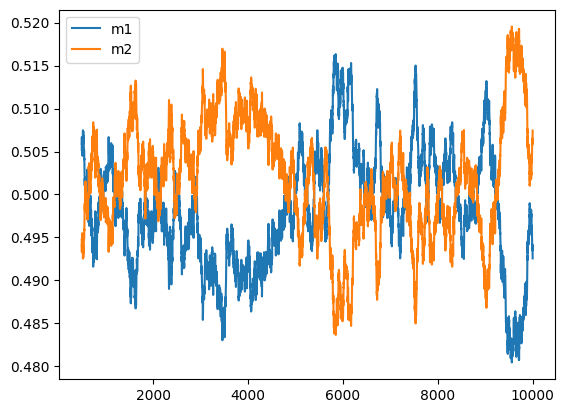

In [318]:
plt.plot(pd.Series(h1losses).rolling(window=500).mean(),label="m1")
plt.plot(pd.Series(h2losses).rolling(window=500).mean(),label="m2")
plt.legend()

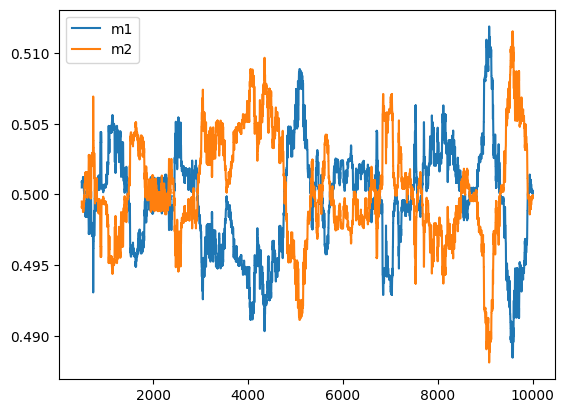

In [319]:
plt.plot(pd.Series(h1losses).rolling(window=500).quantile(.5),label="m1")
plt.plot(pd.Series(h2losses).rolling(window=500).quantile(.5),label="m2")
plt.legend()

In [290]:
h1@h2

tensor(0.4786, grad_fn=<DotBackward0>)

In [291]:
h2

tensor([0.4625, 0.5375], grad_fn=<SoftmaxBackward0>)

In [292]:
h1

tensor([0.7858, 0.2142], grad_fn=<SoftmaxBackward0>)

Parameter containing:
tensor([[ 0.2910,  0.0168,  0.1873, -0.0731,  0.2606, -0.1886,  0.1313, -0.0320,
         -0.1165,  0.1015],
        [ 0.0112, -0.0857,  0.2813,  0.0337, -0.1156,  0.0523,  0.3431, -0.2788,
          0.2103,  0.0963],
        [ 0.2599,  0.1565, -0.2669, -0.2135,  0.0476,  0.1370, -0.0302,  0.0570,
          0.1090,  0.1913],
        [ 0.3960,  0.1018,  0.0493,  0.0766,  0.1767,  0.1402, -0.1928, -0.0935,
         -0.3124, -0.1553],
        [ 0.1149, -0.0438,  0.0340,  0.1413,  0.0938, -0.3498,  0.2613, -0.1578,
         -0.1093,  0.2929],
        [-0.1146, -0.2960, -0.0319,  0.3239, -0.1330,  0.0216, -0.1113, -0.1850,
          0.0782,  0.1786],
        [ 0.0093, -0.2584, -0.1653,  0.0604,  0.0910,  0.1164,  0.1125, -0.1470,
          0.3146, -0.0516],
        [-0.0338,  0.2264, -0.0963, -0.2715, -0.0134,  0.2802, -0.1459,  0.0912,
          0.1482,  0.0728],
        [ 0.0136,  0.0866,  0.2777,  0.0986, -0.2300, -0.1896, -0.1734,  0.0022,
         -0.0544, -0.2485